In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M')
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits import mplot3d
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
import random
import plotly.subplots as sp

In [17]:
def estimate_coef(x, y): 
    n = np.size(x) 
    m_x, m_y = np.mean(x), np.mean(y) 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
    return(b_0, b_1) 
def plot_regression_line(x, y, b): 
    plt.scatter(x, y, color = "m", 
               marker = "o", s = 30) 
    y_pred = b[0] + b[1]*x 
    plt.plot(x, y_pred, color = "g") 
    plt.xlabel('x') 
    plt.ylabel('y') 
    plt.show() 

In [18]:
df = pd.read_csv('./inv3_emi_data_t345678.csv',
                encoding="utf-8-sig",
                header=0,
                infer_datetime_format=True,
                parse_dates={'datetime':[5]},
                index_col=['datetime']
                )

In [19]:
df['time'] = df.index
df.loc[:,'year'] = pd.Series(df.index.year, df.index)
df.loc[:,'month'] = pd.Series(df.index.month, df.index)
df.loc[:,'day'] = pd.Series(df.index.day, df.index)
df.loc[:,'hour'] = pd.Series(df.index.hour, df.index)
df.loc[:,'dayofweek'] = pd.Series(df.index.dayofweek, df.index)
df.loc[:,'dayname'] = pd.Series(df.index.day_name(), df.index)
df.loc[:,'hourofweek'] = pd.Series((df.hour+24*df.dayofweek), df.index)
df.loc[:,'hourofmonth'] = pd.Series((df.hour+24*(df.day-1)), df.index)
df.loc[:,'date'] = pd.Series(df.index.date, df.index)
df=df[(df['Inverter status']=='Grid connected')]
df.loc[:,'Hieu suat']=pd.Series((df['Total input power(kW)']/df['Irradiance(W/㎡)']/2.172/1.303/220*1000*100), df.index)
df=df[df['Hieu suat']<21]
df=df[df['Hieu suat']>16.8]
df=df[df['Irradiance(W/㎡)']>950]
df=df[df['Irradiance(W/㎡)']<1050]
df['date_ordinal'] = pd.to_datetime(df['date']).apply(lambda date: date.toordinal())
df.loc[:,'stt']=pd.Series((df['date_ordinal']-738217-20), df.index)
df=df[df['stt']>=0]
df.head()

,Unnamed: 0.1,Unnamed: 0,Site Name,Management Domain,ManageObject_x,Ambient temperature(℃),PV Temperature(℃),Wind speed(m/s),Wind direction(°),Daily irradiation(MJ/㎡),...,day,hour,dayofweek,dayname,hourofweek,hourofmonth,date,Hieu suat,date_ordinal,stt
datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-23 12:20:00,2945,2945,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,32.5,49.9,1.1,NaN,12.122,...,23,12,2,Wednesday,60,540,2022-03-23,17.299251,738237,0
2022-03-23 12:25:00,2946,2946,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,31.8,50.8,4.0,NaN,12.385,...,23,12,2,Wednesday,60,540,2022-03-23,16.821380,738237,0
2022-03-23 12:35:00,2948,2948,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,31.5,43.5,2.5,NaN,12.857,...,23,12,2,Wednesday,60,540,2022-03-23,18.038025,738237,0
2022-03-24 10:35:00,3079,3079,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,28.3,43.9,1.8,NaN,4.669,...,24,10,3,Thursday,82,562,2022-03-24,17.831494,738238,1
2022-03-24 10:45:00,3081,3081,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,27.4,46.5,2.8,NaN,5.245,...,24,10,3,Thursday,82,562,2022-03-24,17.455226,738238,1


In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Hieu suat'],
    name="Hiệu suất cao nhất mỗi ngày inverter 3 "))
fig . update_traces (
    showlegend = True 
    )
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

In [21]:
df1=df[df.groupby(['month','date'])['Hieu suat'].transform(max)==df['Hieu suat']]

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df1['date'],
    y=df1['Hieu suat'],
    name="Hiệu suất cao nhất mỗi ngày inverter 3 "))
fig . update_traces (
    showlegend = True 
    )
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

In [23]:
def estimate_coef(x, y): 
    n = np.size(x) 
    m_x, m_y = np.mean(x), np.mean(y) 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
    return(b_0, b_1) 
def plot_regression_line(x, y, b): 
    plt.scatter(x, y, color = "m", 
               marker = "o", s = 30) 
    y_pred = b[0] + b[1]*x 
    plt.plot(x, y_pred, color = "g") 
    plt.xlabel('x') 
    plt.ylabel('y') 
    plt.show() 

In [24]:
df2=df[df.groupby(['month','date'])['Total input power(kW)'].transform(max)==df['Total input power(kW)']]

In [25]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=df2['date'],
    y=df2['Hieu suat'],
    name="Hiệu suất cao nhất mỗi ngày inverter 3 "))
fig2 . update_traces (
    showlegend = True 
    )
fig2.update_xaxes(
    rangeslider_visible=True,
)
fig2.show()

Estimated coefficients:
b_0 = 17.61347746975581
b_1 = -0.003828039939164449


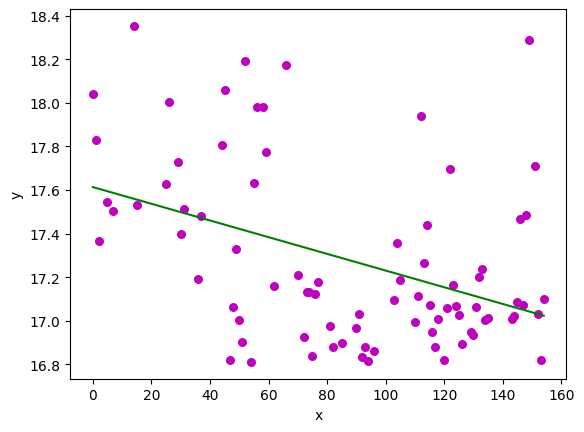

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15156\3648078888.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15156\3648078888.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
df_bin = df1[['Hieu suat','month','stt']] 
x = len(df_bin)
num_index = range(0,x,1)
a=df_bin['stt'][x-1]
df_bin =  df_bin.reset_index()
df_bin.head() 
x=df_bin['stt'].tolist()
y=df_bin['Hieu suat'].tolist()
x=np.array(x)
y=np.array(y)
mymodel = np.poly1d(np.polyfit(x, y, 1))
myline = np.linspace(0, 154, 100)

fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=x,
    y=y,
    name="Hiệu suất"))
fig1.add_trace(go.Scatter(
    x=myline,
    y=mymodel(myline),
    name="Hiệu suất khớp"))
fig1.show()
b = estimate_coef(x, y) 
print("Estimated coefficients:\nb_0 = {}\nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(x, y, b) 
y_pred= b[0] + b[1]*x
df1.loc[:,'hstt']=pd.Series((df1['stt']*b[1]+b[0]), df.index)
df1.loc[:,'saiso']=pd.Series(((df1['Hieu suat']-df1['hstt'])/df1['hstt']), df.index)
df1=df1[abs(df1['saiso'])<=0.02]

Estimated coefficients:
b_0 = 17.55740533441041
b_1 = -0.004049634974471158


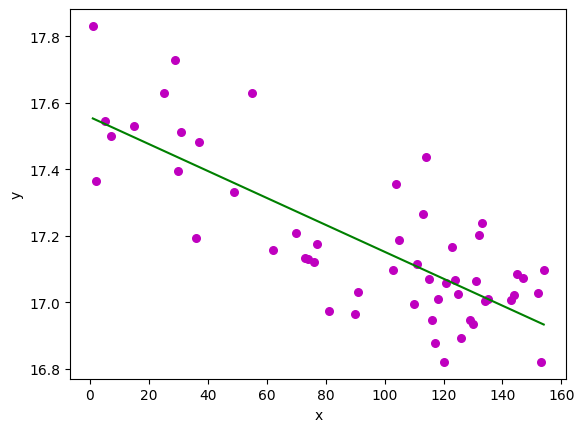

In [27]:
df_bin = df1[['Hieu suat','month','stt']] 
x = len(df_bin)
num_index = range(0,x,1)
a=df_bin['stt'][x-1]
df_bin =  df_bin.reset_index()
df_bin.head() 
x=df_bin['stt'].tolist()
y=df_bin['Hieu suat'].tolist()
x=np.array(x)
y=np.array(y)
mymodel = np.poly1d(np.polyfit(x, y, 1))
myline = np.linspace(0, 154, 100)

fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=x,
    y=y,
    name="Hiệu suất"))
fig1.add_trace(go.Scatter(
    x=myline,
    y=mymodel(myline),
    name="Hiệu suất khớp"))
fig1.show()
b = estimate_coef(x, y) 
print("Estimated coefficients:\nb_0 = {}\nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(x, y, b) 
y_pred= b[0] + b[1]*x

Estimated coefficients:
b_0 = 17.53237753866716
b_1 = -0.003985824112018715


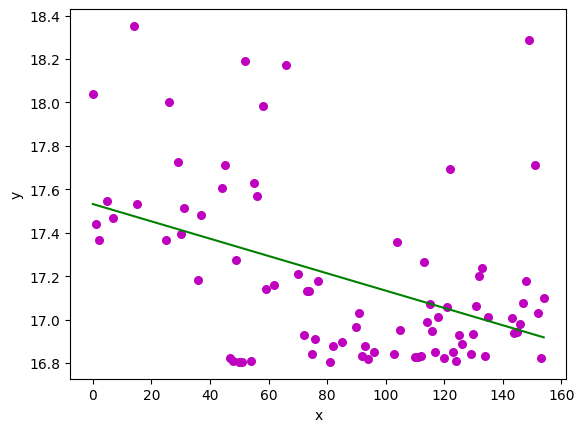

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15156\2537770698.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15156\2537770698.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
df_bin = df2[['Hieu suat','month','stt']] 
x = len(df_bin)
num_index = range(0,x,1)
a=df_bin['stt'][x-1]
df_bin =  df_bin.reset_index()
df_bin.head() 
x=df_bin['stt'].tolist()
y=df_bin['Hieu suat'].tolist()
x=np.array(x)
y=np.array(y)
mymodel = np.poly1d(np.polyfit(x, y, 1))
myline = np.linspace(0, 154, 100)

fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=x,
    y=y,
    name="Hiệu suất"))
fig2.add_trace(go.Scatter(
    x=myline,
    y=mymodel(myline),
    name="Hiệu suất khớp"))
fig2.show()
b = estimate_coef(x, y) 
print("Estimated coefficients:\nb_0 = {}\nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(x, y, b) 
y_pred= b[0] + b[1]*x
df2.loc[:,'hstt']=pd.Series((df2['stt']*b[1]+b[0]), df.index)
df2.loc[:,'saiso']=pd.Series(((df2['Hieu suat']-df2['hstt'])/df2['hstt']), df.index)
df2=df2[abs(df2['saiso'])<=0.02]

Estimated coefficients:
b_0 = 17.475167253218263
b_1 = -0.0040558127532966245


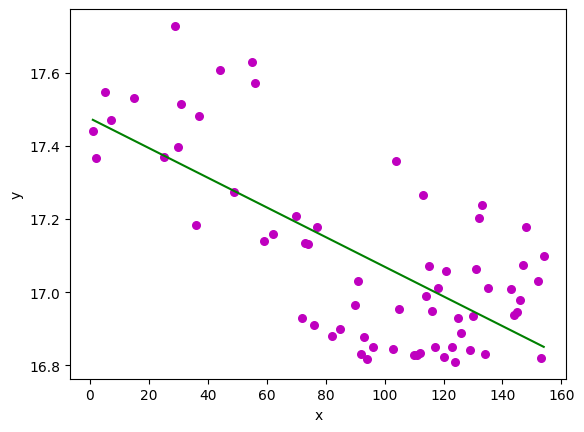

In [29]:
df_bin = df2[['Hieu suat','month','stt']] 
x = len(df_bin)
num_index = range(0,x,1)
a=df_bin['stt'][x-1]
df_bin =  df_bin.reset_index()
df_bin.head() 
x=df_bin['stt'].tolist()
y=df_bin['Hieu suat'].tolist()
x=np.array(x)
y=np.array(y)
mymodel = np.poly1d(np.polyfit(x, y, 1))
myline = np.linspace(0, 154, 100)

fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=x,
    y=y,
    name="Hiệu suất"))
fig2.add_trace(go.Scatter(
    x=myline,
    y=mymodel(myline),
    name="Hiệu suất khớp"))
fig2.show()
b = estimate_coef(x, y) 
print("Estimated coefficients:\nb_0 = {}\nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(x, y, b) 
y_pred= b[0] + b[1]*x

In [30]:
df1.to_csv('hscaonhat.csv')
df2.to_csv('totalcaonhat.csv')